Scaling constant k: 3.2666
Acceptance Rate: 30.89%


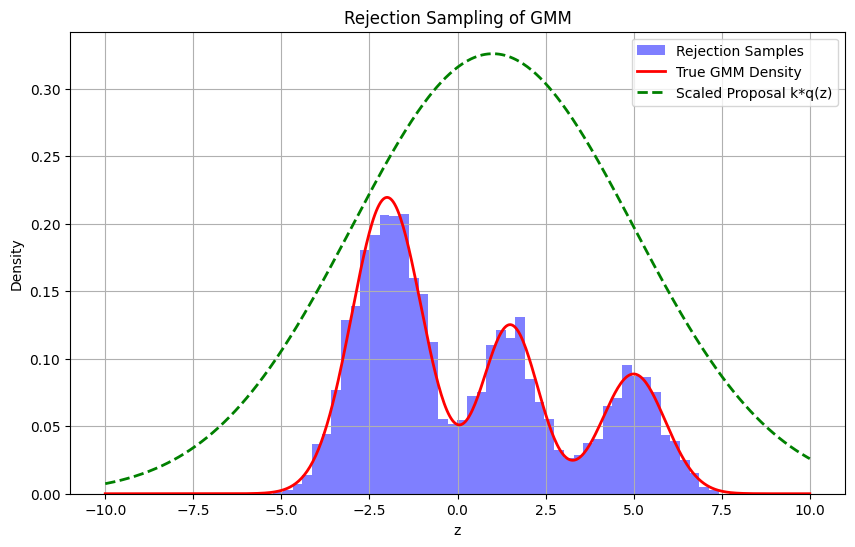

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Gaussian mean model from proj 5
true_pi = np.array([0.55, 0.25, 0.20])
true_mu = np.array([-2.0, 1.5, 5.0])
true_sigma = np.sqrt(np.array([1**2, 0.8**2, 0.9**2])) # Standard deviations

def gmm_pdf(x):
    density = 0
    for k in range(len(true_pi)):
        density += true_pi[k] * norm.pdf(x, true_mu[k], true_sigma[k])
    return density

# define a proposal distribution which we draw samples from
q_mu = 1.0
q_sigma = 4.0
def proposal_pdf(x):
    return norm.pdf(x, q_mu, q_sigma)

def sample_proposal(n=1):
    return np.random.normal(q_mu, q_sigma, n)

x_scan = np.linspace(-10, 10, 1000)
# make a constant such that k*q(z)>= p(z) for all values z
k = np.max(gmm_pdf(x_scan) / proposal_pdf(x_scan))
# multiplied by 1.1 just to be safe
k *= 1.1

print(f"Scaling constant k: {k:.4f}")

num_samples = 5000
samples = []
accepted = 0
total_attempts = 0

while accepted < num_samples:
    total_attempts += 1

    # need to draw a sample from the proposal distribution
    # basically where on the x-axis to draw a value
    z0 = sample_proposal(1)[0]

    # generate uniform random number u0 from [0, k*q(z0)]
    # pick a random height at the location z0 between 0 and k*q(z0)
    u0 = np.random.uniform(0, k * proposal_pdf(z0))

    # if what we picked is below the target cieling (u<= p(z)) -> keep sample
    # otherwise we reject the sample if u > p(z)
    if u0 <= gmm_pdf(z0):
        samples.append(z0)
        accepted += 1

print(f"Acceptance Rate: {num_samples / total_attempts:.2%}")

plt.figure(figsize=(10, 6))
plt.hist(samples, bins=50, density=True, alpha=0.5, color='blue', label='Rejection Samples') #samples we kept

x_plot = np.linspace(-10, 10, 500)
plt.plot(x_plot, gmm_pdf(x_plot), 'r-', linewidth=2, label='True GMM Density') # true GMM

plt.plot(x_plot, k * proposal_pdf(x_plot), 'g--', linewidth=2, label='Scaled Proposal k*q(z)') # scaled k*q(z)

plt.title('Rejection Sampling of GMM')
plt.xlabel('z')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

MCMC Acceptance Rate: 55.83%
True Weights: w0 = -0.3, w1 = 0.5
Estimated Weights: w0 = -0.2556, w1 = 0.6010


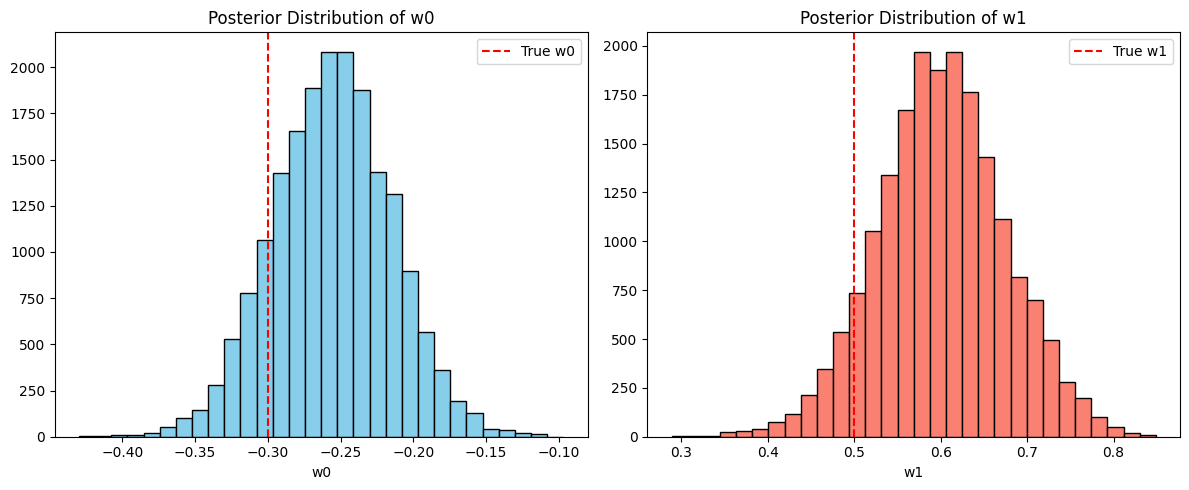

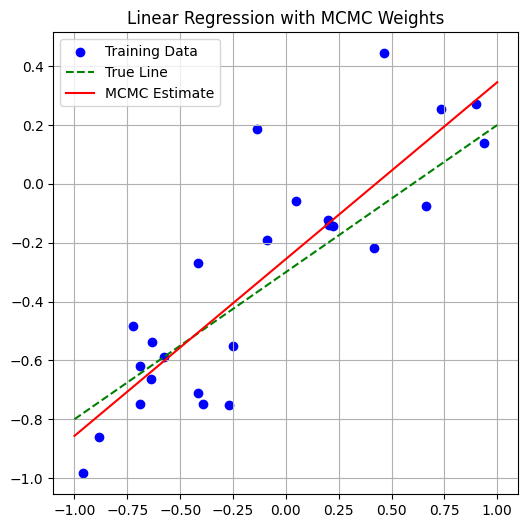

In [5]:
# copied directly from project 2 function with some additive gaussian noise
np.random.seed(42)
def generate_linear_data(n, noise=0.2):
    x = np.random.uniform(-1, 1, n)
    # True weights: w0 = -0.3, w1 = 0.5
    t = -0.3 + 0.5 * x + np.random.normal(0, noise, n)
    return x, t

N = 25
x_data, t_data = generate_linear_data(N)
beta = 25.0  # known noise precision (1/sigma^2 = 1/0.2^2 = 25)
alpha = 2.0  # prior precision


def log_likelihood(w, x, t, beta):
    y_pred = w[0] + w[1] * x

    # sum of squared errors (how far off are we)
    sse = np.sum((t - y_pred)**2)

    # if we do the math we get log likelihood log(p(t|w)) to bejust -beta/2 * sse
    return -0.5 * beta * sse

def log_prior(w, alpha):
    # the log prior p(w) is just alpha/2*w^T*w
    return -0.5 * alpha * np.sum(w**2)

def log_posterior(w, x, t, beta, alpha):
    # log posterior is proportional to log likelihood + log prior (bayes thm)
    return log_likelihood(w, x, t, beta) + log_prior(w, alpha)



num_iterations = 20000 # how many actual steps we take
step_size = 0.05 # how much we 'jump' like in the visualization

# start at origin
w_current = np.array([0.0, 0.0])
samples = []
accepted_count = 0
log_p_current = log_posterior(w_current, x_data, t_data, beta, alpha)

for i in range(num_iterations):
    # propose a new position basically 2 random numbers from normal distribution
    # this is our proposal distribution q(w*|w)
    w_prop = w_current + np.random.normal(0, step_size, 2)

    # get the log posterior for this state
    log_p_prop = log_posterior(w_prop, x_data, t_data, beta, alpha)

    # calculate the acceptance probability
    # A = min(1, p_prop / p_current) straight from the book
    # log(A) = min(0, log_p_prop - log_p_current)
    log_acceptance_ratio = log_p_prop - log_p_current

    # generate a uniform u in [0,1], take log for comparison
    # we accept the change if the drawn number is smaller than A
    # we use logs because values get incredibly small otherwise
    if np.log(np.random.rand()) < log_acceptance_ratio:
        w_current = w_prop
        log_p_current = log_p_prop
        accepted_count += 1

    samples.append(w_current)

# because we started in a random spot we need some time for the markov chainto actually converge to the distribution
burn_in = 1000
chain = np.array(samples[burn_in:])

w0_est = np.mean(chain[:, 0])
w1_est = np.mean(chain[:, 1])

print(f"MCMC Acceptance Rate: {accepted_count / num_iterations:.2%}")
print(f"True Weights: w0 = -0.3, w1 = 0.5")
print(f"Estimated Weights: w0 = {w0_est:.4f}, w1 = {w1_est:.4f}")


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(chain[:, 0], bins=30, color='skyblue', edgecolor='black')
plt.axvline(-0.3, color='r', linestyle='--', label='True w0')
plt.title('Posterior Distribution of w0')
plt.xlabel('w0')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(chain[:, 1], bins=30, color='salmon', edgecolor='black')
plt.axvline(0.5, color='r', linestyle='--', label='True w1')
plt.title('Posterior Distribution of w1')
plt.xlabel('w1')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(x_data, t_data, color='blue', label='Training Data')
x_range = np.linspace(-1, 1, 100)
y_est = w0_est + w1_est * x_range
y_true = -0.3 + 0.5 * x_range
plt.plot(x_range, y_true, 'g--', label='True Line')
plt.plot(x_range, y_est, 'r-', label='MCMC Estimate')
plt.title('Linear Regression with MCMC Weights')
plt.legend()
plt.grid(True)
plt.show()

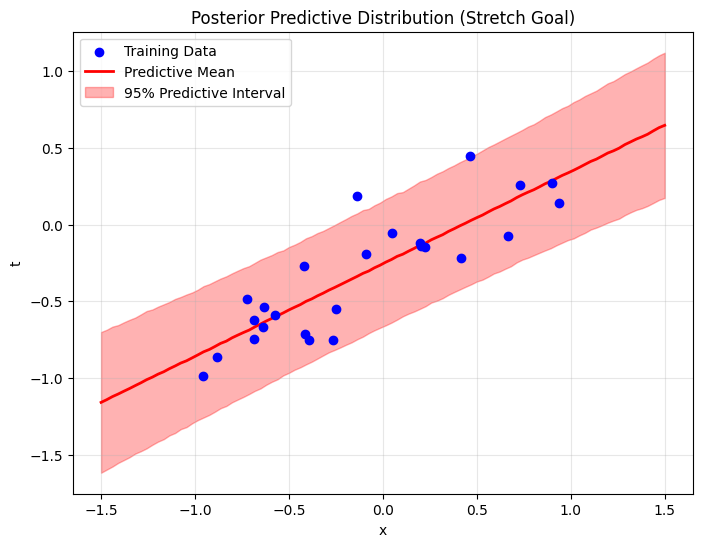

In [7]:
# --- Stretch Goal: Predictive Distribution ---

# 1. Create a grid of x values to predict on
x_test = np.linspace(-1.5, 1.5, 100)
predictions = []

# 2. Iterate through your MCMC samples
for w in chain:
    # A. Calculate the line for this specific weight sample (Model Uncertainty)
    y_line = w[0] + w[1] * x_test

    # B. Add Gaussian Noise (Data Uncertainty)
    # The standard deviation is 1 / sqrt(precision) -> 1 / sqrt(beta)
    # This simulates where a REAL new data point would land, not just the mean
    noise = np.random.normal(0, 1.0/np.sqrt(beta), len(x_test))

    # C. Store the full prediction
    predictions.append(y_line + noise)

# 3. Calculate Statistics
predictions = np.array(predictions)
mean_pred = predictions.mean(axis=0)
std_pred = predictions.std(axis=0)

# 4. Plotting
plt.figure(figsize=(8, 6))

# Plot the training data points
plt.scatter(x_data, t_data, color='blue', label='Training Data', zorder=5)

# Plot the Mean Prediction (The average line)
plt.plot(x_test, mean_pred, 'r-', linewidth=2, label='Predictive Mean')

# Plot the 95% Predictive Interval (Mean +/- 2 Sigma)
# This shows where we expect 95% of NEW data to fall, accounting for all uncertainty
plt.fill_between(x_test,
                 mean_pred - 2*std_pred,
                 mean_pred + 2*std_pred,
                 color='red', alpha=0.3, label='95% Predictive Interval')

plt.title('Posterior Predictive Distribution (Stretch Goal)')
plt.xlabel('x')
plt.ylabel('t')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

posterior predictive at x_new = 0.5:
true t = -0.050
mean = 0.043
Std = 0.208
95% CI = [-0.365, 0.450]


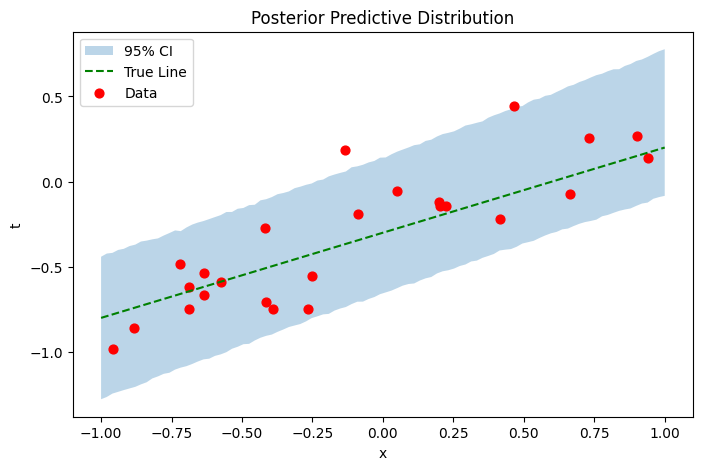

<Figure size 640x480 with 0 Axes>

In [11]:
# convert our precision (beta) to a standard edeviation
# this is the observation noise in our model
noise_std = 1.0 / np.sqrt(beta)  # sigma = 0.2

# Pick a new x value to predict t
x_new = 0.5

# now for each posterior sample we calculate a different predicted mean at x_new
means = chain[:, 0] + chain[:, 1] * x_new

# now add the random guaussian noise to each mean
# this gives us about 19000 samples from the posterior predictive distribution
t_predictive = means + np.random.normal(0, noise_std, size=len(chain))

# Since MCMC already gives you posterior samples of w,
# just use them directly to generate predictions. No need for nested MCMC loops
print(f"posterior predictive at x_new = {x_new}:")
print(f"true t = {-0.3 + 0.5 * x_new:.3f}")
print(f"mean = {np.mean(t_predictive):.3f}")
print(f"Std = {np.std(t_predictive):.3f}")
print(f"95% CI = [{np.percentile(t_predictive, 2.5):.3f}, {np.percentile(t_predictive, 97.5):.3f}]")


x_range = np.linspace(-1, 1, 100)
preds = chain[:, 0][:, None] + chain[:, 1][:, None] *x_range
preds += np.random.normal(0, noise_std, preds.shape)

plt.figure(figsize=(8, 5))
plt.fill_between(x_range, np.percentile(preds, 2.5, axis=0),
                 np.percentile(preds, 97.5, axis=0), alpha=0.3, label='95% CI')
plt.plot(x_range, -0.3 + 0.5 *x_range, 'g--', label='True Line')
plt.scatter(x_data, t_data, c='red', s=40, label='Data')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Posterior Predictive Distribution')
plt.legend()
plt.show()
plt.tight_layout()
plt.show()